In [1]:
%load_ext tikzmagic
%matplotlib inline

# 과최적화와 정규화

회귀분석을 하는 1차 목적은 종속변수와 독립변수의 관계를 알아내는 것이지만 2차 목적은 독립변수 데이터를 이용하여 종속변수를 예측하는 것이다. 그런데 이미 종속변수 값을 알고 있는 경우는 사실 예측을 할 필요가 없다. 종속변수 값 예측이 필요한 경우는 독립변수만 알고 있고 종속변수를 모르는 경우다. 보스턴 집값 데이터를 예로 들자면 보스턴에 새로운 지역이 생겨서 방의 평균 개수 등 독립변수 값은 알고 있지만 집값이라는 종속변수 값을 모를 때 이를 대강이라도 예측하기 위한 것이다. 따라서 이미 회귀분석에 사용된 데이터를 예측하는 것보다 중요한 것이 회귀분석에 사용되지 않은 데이터에 대해 예측을 잘 할 수 있어야 한다.

예측식을 구하기 위해 이미 회귀분석에 사용된 데이터를 <b>학습 데이터(traing data)</b>라 하고 이 데이터의 예측 성능을 <b>표본내(in-sample) 예측 성능</b>이라 한다. 올바른 예측 성능을 구하려면 회귀분석에 사용되지 않은 데이터에 대해서도 예측을 잘 할 수 있는지를 검증해야 한다. 회귀분석에 사용되지 않았지만 종속변수 값을 가지고 있어 예측 성능을 검증하는데 쓰일 수 있는 데이터를 <b>검증 데이터(test data)</b>라 하고 이를 이용한 예측 성능을 <b>표본외(out-of-sample) 예측 성능</b>이라고 한다. 예측이 회귀분석의 주된 목표라면 중요한 것은 표본내 예측 성능이 아니라 분석에 사용되지 않은 별개의 새로운 데이터를 넣었을 때 얼마나 예측을 잘 하는지를 알려주는 표본외 예측 성능이다. 표본외 성능을 계산할 때는 가지고 있는 데이터를 두 개로 나누어 하나를 학습 데이터로 사용한 회귀분석을 하고 나머지 데이터를 검증 데이터로 사용하여 표본외 성능을 알아보는 것이 일반적이다. 이러한 방법을 <b>교차검증(cross-validation)</b>이라고 한다. 

이 때 학습 데이터를 이용한 표본내 성능을 높이기 위해 독립변수의 수를 너무 많이 늘리거나 너무 복잡한 비선형 모형을 사용하게 되면 표본내 성능은 높아지지만 표본외 성능이 하락하는 <b>과최적화(over-fitting)</b> 현상이 발생할 수 있다. 따라서 회귀분석을 할 때는 교차검증을 통해 과최적화가 발생하지 않도록 해야 한다. 

이 절에서는 보스턴 집값 데이터를 사용하여 과최적화가 발생하는 현상을 살펴보고 이를 막기 위해 어떠한 조치를 취해야하는지를 설명한다.

## 과최적화

우선 교차검증을 위해 보스턴 집값 데이터를 100개의 학습 데이터와 나머지 검증 데이터로 분리한다.

In [2]:
import statsmodels.api as sm

boston = sm.datasets.get_rdataset("Boston", "MASS").data
boston_train = boston.iloc[:100]
boston_test = boston.iloc[100:]

lstat 값을 독립변수로 사용하는 간단한 회귀분석을 한 결과는 다음과 같다.

In [3]:
x_name = "lstat"
formula = f"medv ~ scale({x_name})"
result1 = sm.OLS.from_formula(formula, boston_train).fit()
print(result1.summary())

                            OLS Regression Results                            
Dep. Variable:                   medv   R-squared:                       0.553
Model:                            OLS   Adj. R-squared:                  0.549
Method:                 Least Squares   F-statistic:                     121.4
Date:                Wed, 10 Aug 2022   Prob (F-statistic):           7.54e-19
Time:                        14:13:14   Log-Likelihood:                -279.06
No. Observations:                 100   AIC:                             562.1
Df Residuals:                      98   BIC:                             567.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       22.3090      0.398     56.027   

이제 이 회귀분석의 표본내 성능을 늘리기 위해 앞 절에서 설명한 다항회귀를 실시한다. 다음은 다항회귀의 차수를 8차까지 늘리면서 회귀분석을 반복 실시하는 코드다.

In [4]:
N = 8

results = {1: result1}
for i in range(2, N + 1):
    formula += f" + scale(I({x_name} ** {i}))"
    result_i = sm.OLS.from_formula(formula, boston_train).fit()
    results[i] = result_i

이렇게 다항회귀의 차수를 늘렸을 때 표본내 성능을 결정계수 $R^2$와 잔차제곱합 RSS로 살펴보면 다음과 같이 차수를 늘림에 따라 결정계수가 계속 증가하고 잔차제곱합이 계속 감소하는 것을 알 수 있다. 

In [5]:
df_rss = pd.DataFrame.from_records(
    [(i, r.rsquared, r.ssr) for i, r in results.items()],
    columns=["차수", "학습 결정계수", "학습 잔차제곱합"]
).set_index("차수")

df_rss.style.bar()

,학습 결정계수,학습 잔차제곱합
차수,,
1,0.553373,1553.790601
2,0.686105,1092.022691
3,0.710969,1005.522571
4,0.723554,961.739072
5,0.723823,960.802511
6,0.728595,944.200845
7,0.729950,939.488687
8,0.740790,901.775330


결정계수와 잔차제곱합이 변하는 모습은 다음 그림과 같다. 이 결과만 보면 마치 차수가 가장 높은 8차 다항회귀모형을 선택하는 것이 옳은 결정인 것 처럼 보인다.

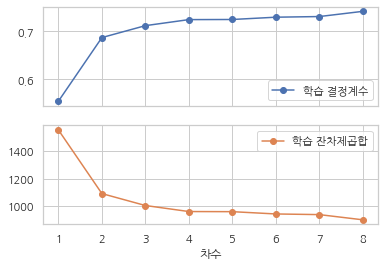

In [6]:
df_rss.plot(y=["학습 결정계수", "학습 잔차제곱합"], marker="o", subplots=True)
plt.show()

다음은 과최적화가 발생하는지 살펴보기 위해 학습 데이터와 예측 결과를 시각화하여 표시한 것이다. 차수가 증가함에 따라 예측식의 모양이 복잡해지면서 학습에 사용된 데이터는 더 잘 예측하지만 학습에 사용되지 않은 lstat 값에 대해서는  상식적으로 나올 수 없는 값을 예측하는 것을 볼 수 있다.

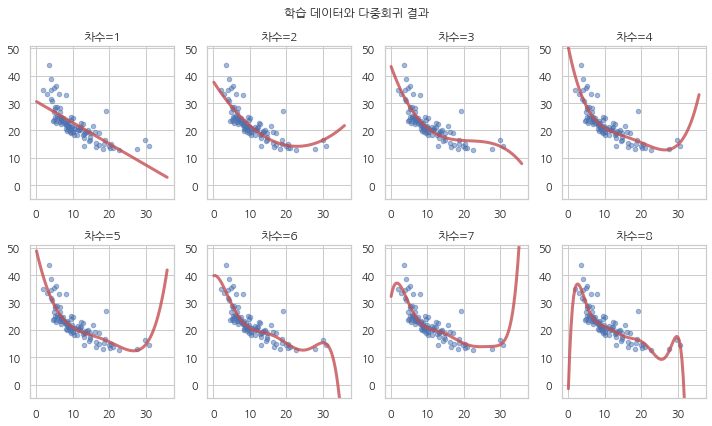

In [7]:
import pandas as pd

def plot_train(results, i, subplot):
    r_i = results[i]
    x = pd.DataFrame({x_name: np.linspace(0.1, 35.9, 100)})
    y = r_i.get_prediction(x).summary_frame()

    plt.subplot(*subplot)
    plt.scatter(boston_train[x_name], boston_train["medv"], marker='o', s=20, alpha=0.5)
    plt.plot(x[x_name].values, y["mean"].values, lw=3, alpha=0.8, c="r")
    plt.ylim(-5, 51)
    plt.title(f"차수={i}")

plt.figure(figsize=(10, 6))
for i in range(1, 9):
    plot_train(results, i, [2, 4, i])
plt.suptitle("학습 데이터와 다중회귀 결과")
plt.tight_layout()
plt.show()

예를 들어 8차 다항회귀모형은 lstat 값이 34.5 일 때 집값을 -238.9 라고 예측한다. 

In [8]:
result8 = results[8]
result8.get_prediction(pd.DataFrame({"lstat": [34.5]})).predicted_mean

array([-238.93065284])

하지만 검증 데이터에서 lstat 값이 33~35 사이인 데이터를 찾아보면 실제로는 집값이 8.4 ~ 17.9 범위인 것을 알 수 있다.

In [15]:
boston_test[(boston_test.lstat > 34) & (boston_test.lstat < 35)][["lstat", "medv"]]

,lstat,medv
141,34.41,14.4
373,34.77,13.8
412,34.37,17.9
438,34.02,8.4


다음은 학습에 사용하지 않은 검증 데이터와 예측식을 비교한 그림이다. 차수가 증가하면서 실제 집값과는 동떨어진 값을 예측하고 있음을 알 수 있다.

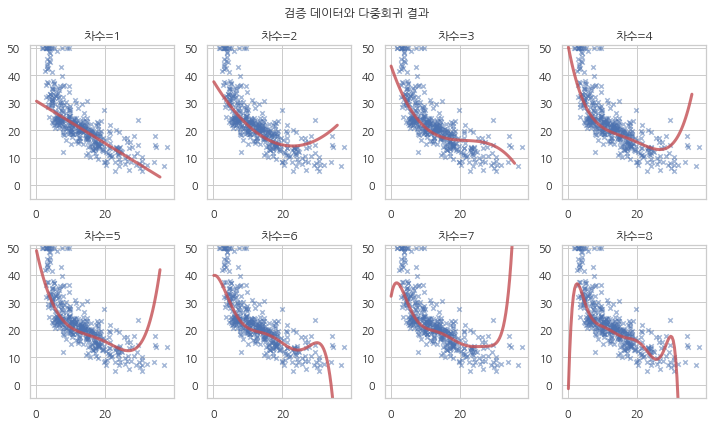

In [10]:
def plot_test(results, i, subplot):
    r_i = results[i]
    x = pd.DataFrame({x_name: np.linspace(0.1, 35.9, 100)})
    y = r_i.get_prediction(x).summary_frame()

    plt.subplot(*subplot)
    plt.scatter(boston_test[x_name], boston_test["medv"], marker='x', s=20, alpha=0.5)
    plt.plot(x[x_name].values, y["mean"].values, lw=3, alpha=0.8, c="r")
    plt.ylim(-5, 51)
    plt.title(f"차수={i}")

plt.figure(figsize=(10, 6))
for i in range(1, 9):
    plot_test(results, i, [2, 4, i])
plt.suptitle("검증 데이터와 다중회귀 결과")
plt.tight_layout()
plt.show()

검증 데이터에 대한 잔차제곱합을 구해보면 다음과 같다.

In [11]:
rss_test = []
for i, r in results.items():
    y_true = boston_test.medv
    y_pred = r.get_prediction(boston_test).predicted_mean
    rss_test.append(((y_true - y_pred) ** 2).sum())

df_rss["검증 잔차제곱합"] = rss_test
df_rss[["검증 잔차제곱합"]].style.bar()

,검증 잔차제곱합
차수,
1,20145.399074
2,17656.438628
3,16362.769041
4,18075.527274
5,21171.613313
6,32154.412838
7,49392.894713
8,5070235.057569


차수가 3차까지 증가할 때는 잔차제곱합이 감소하지만 그 이후에는 오히려 잔차제곱합이 증가하여 예측 오차가 커지는 것을 알 수 있다. 이러한 현상을 과최적화라고 부른다. 과최적화를 막으려면 다항회귀를 할 때 표본내 성능을 사용하지 말고 표본외 성능을 이용해야 한다. 따라서 다항회귀의 차수는 가장 표본내 성능이 좋은 8차 모형이 아니라 가장 표본외 성능이 좋은  3차 모형을 사용해야 한다.

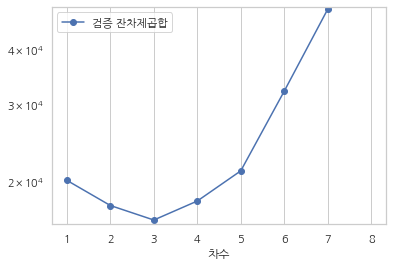

In [12]:
df_rss.plot(y=["검증 잔차제곱합"], logy=True, marker="o")
plt.ylim(1.6e4, 5e4)
plt.show()

## 조정 성능

In [13]:
df_adj = pd.DataFrame.from_records(
    [(i, r.rsquared_adj, r.aic, r.bic) for i, r in results.items()],
    columns=["차수", "조정 결정계수", "AIC", "BIC"]
).set_index("차수")
df_adj.style.bar(width=80)

,조정 결정계수,AIC,BIC
차수,,,
1,0.548815,562.115965,567.326306
2,0.679633,528.849382,536.664892
3,0.701937,522.596954,533.017634
4,0.711914,520.145006,533.170857
5,0.709133,522.047577,537.678598
6,0.711085,522.304578,540.540770
7,0.709403,523.804266,544.645627
8,0.718003,521.707229,545.153761


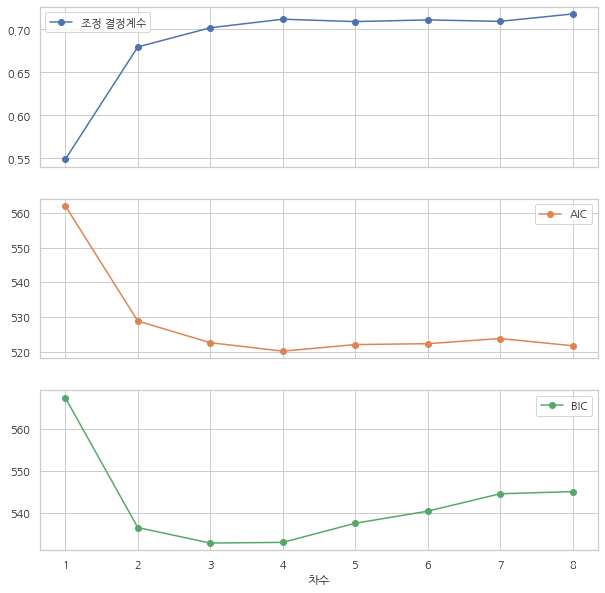

In [14]:
df_adj.plot(marker="o", subplots=True, figsize=(10, 10))
plt.show()

## 정규화